# Traffic Sign Classification with Keras

Keras exists to make coding deep neural networks simpler. To demonstrate just how easy it is, you’re going to use Keras to build a convolutional neural network in a few dozen lines of code.

You’ll be connecting the concepts from the previous lessons to the methods that Keras provides.

## Dataset

The network you'll build with Keras is similar to the example in Keras’s GitHub repository that builds out a [convolutional neural network for MNIST](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py). 

However, instead of using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, you're going to use the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) dataset that you've used previously.

You can download pickle files with sanitized traffic sign data here:

In [1]:
from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/train.p',
            'train.p',
            pbar.hook)

if not isfile('test.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Test Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/test.p',
            'test.p',
            pbar.hook)

print('Training and Test data downloaded.')

Training and Test data downloaded.


## Overview

Here are the steps you'll take to build the network:

1. Load the training data.
2. Preprocess the data.
3. Build a feedforward neural network to classify traffic signs.
4. Build a convolutional neural network to classify traffic signs.
5. Evaluate the final neural network on testing data.

Keep an eye on the network’s accuracy over time. Once the accuracy reaches the 98% range, you can be confident that you’ve built and trained an effective model.

In [2]:
import pickle
import numpy as np
import math

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

print('Modules loaded.')

Modules loaded.


## Load the Data

Start by importing the data from the pickle file.

In [3]:
with open('train.p', 'rb') as f:
    data = pickle.load(f)

# TODO: Load the feature data to the variable X_train
X_train = data['features']
# TODO: Load the label data to the variable y_train
y_train = data['labels']

In [4]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert np.array_equal(X_train, data['features']), 'X_train not set to data[\'features\'].'
assert np.array_equal(y_train, data['labels']), 'y_train not set to data[\'labels\'].'
assert len(X_train)==len(y_train), 'Length mismatch between training data and labels'
print('Tests passed.')

Tests passed.


## Preprocess the Data

1. Shuffle the data
2. Normalize the features using Min-Max scaling between -0.5 and 0.5
3. One-Hot Encode the labels

### Shuffle the data
Hint: You can use the [scikit-learn shuffle](http://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html) function to shuffle the data.

In [5]:
# TODO: Shuffle the data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train) 

In [6]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert X_train.shape == data['features'].shape, 'X_train has changed shape. The shape shouldn\'t change when shuffling.'
assert y_train.shape == data['labels'].shape, 'y_train has changed shape. The shape shouldn\'t change when shuffling.'
assert not np.array_equal(X_train, data['features']), 'X_train not shuffled.'
assert not np.array_equal(y_train, data['labels']), 'y_train not shuffled.'
print('Tests passed.')

Tests passed.


### Normalize the features
Hint: You solved this in [TensorFlow lab](https://github.com/udacity/CarND-TensorFlow-Lab/blob/master/lab.ipynb) Problem 1.

In [7]:
# TODO: Normalize the data features to the variable X_normalized
# TODO: Try alternatives
def normalize_grayscale(image_data):
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

X_normalized = normalize_grayscale(X_train)

In [8]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert math.isclose(np.min(X_normalized), -0.5, abs_tol=1e-5) and math.isclose(np.max(X_normalized), 0.5, abs_tol=1e-5), 'The range of the training data is: {} to {}.  It must be -0.5 to 0.5'.format(np.min(X_normalized), np.max(X_normalized))
print('Tests passed.')

Tests passed.


### One-Hot Encode the labels
Hint: You can use the [scikit-learn LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) function to one-hot encode the labels.

In [9]:
# TODO: One Hot encode the labels to the variable y_one_hot
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_one_hot = lb.fit_transform(y_train)

In [10]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
import collections

assert y_one_hot.shape == (39209, 43), 'y_one_hot is not the correct shape.  It\'s {}, it should be (39209, 43)'.format(y_one_hot.shape)
assert next((False for y in y_one_hot if collections.Counter(y) != {0: 42, 1: 1}), True), 'y_one_hot not one-hot encoded.'
print('Tests passed.')

Tests passed.


## Keras Sequential Model
```python
from keras.models import Sequential

# Create the Sequential model
model = Sequential()
```
The `keras.models.Sequential` class is a wrapper for the neural network model. Just like many of the class models in scikit-learn, it provides common functions like `fit()`, `evaluate()`, and `compile()`.  We'll cover these functions as we get to them.  Let's start looking at the layers of the model.

## Keras Layer
A Keras layer is just like a neural network layer.  It can be fully connected, max pool, activation, etc.  You can add a layer to the model using the model's `add()` function.  For example, a simple model would look like this:
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten

# Create the Sequential model
model = Sequential()

# 1st Layer - Add a flatten layer
model.add(Flatten(input_shape=(32, 32, 3)))

# 2nd Layer - Add a fully connected layer
model.add(Dense(100))

# 3rd Layer - Add a ReLU activation layer
model.add(Activation('relu'))

# 4th Layer - Add a fully connected layer
model.add(Dense(60))

# 5th Layer - Add a ReLU activation layer
model.add(Activation('relu'))
```
Keras will automatically infer the shape of all layers after the first layer.  This means you only have to set the input dimensions for the first layer.

The first layer from above, `model.add(Flatten(input_shape=(32, 32, 3)))`, sets the input dimension to (32, 32, 3) and output dimension to (3072=32\*32\*3).  The second layer takes in the output of the first layer and sets the output dimenions to (100).  This chain of passing output to the next layer continues until the last layer, which is the output of the model.

## Build a Multi-Layer Feedforward Network

Build a multi-layer feedforward neural network to classify the traffic sign images.

1. Set the first layer to a `Flatten` layer with the `input_shape` set to (32, 32, 3)
2. Set the second layer to `Dense` layer width to 128 output. 
3. Use a ReLU activation function after the second layer.
4. Set the output layer width to 43, since there are 43 classes in the dataset.
5. Use a softmax activation function after the output layer.

To get started, review the Keras documentation about [models](https://keras.io/models/sequential/) and [layers](https://keras.io/layers/core/).

The Keras example of a [Multi-Layer Perceptron](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py) network is similar to what you need to do here. Use that as a guide, but keep in mind that there are a number of differences.

In [12]:
from keras.models import Sequential
model = Sequential()
# TODO: Build a Multi-layer feedforward neural network with Keras here.
from keras.layers.core import Dense, Activation, Flatten
model.add(Flatten(input_shape=(32, 32, 3))) # L1
model.add(Dense(128)) # L2
model.add(Activation('relu')) # L3
model.add(Dense(43)) # L4
model.add(Activation('softmax')) # L5 - Output layer

In [13]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
from keras.layers.core import Dense, Activation, Flatten
from keras.activations import relu, softmax

def check_layers(layers, true_layers):
    assert len(true_layers) != 0, 'No layers found'
    for layer_i in range(len(layers)):
        assert isinstance(true_layers[layer_i], layers[layer_i]), 'Layer {} is not a {} layer'.format(layer_i+1, layers[layer_i].__name__)
    assert len(true_layers) == len(layers), '{} layers found, should be {} layers'.format(len(true_layers), len(layers))

check_layers([Flatten, Dense, Activation, Dense, Activation], model.layers)

assert model.layers[0].input_shape == (None, 32, 32, 3), 'First layer input shape is wrong, it should be (32, 32, 3)'
assert model.layers[1].output_shape == (None, 128), 'Second layer output is wrong, it should be (128)'
assert model.layers[2].activation == relu, 'Third layer not a relu activation layer'
assert model.layers[3].output_shape == (None, 43), 'Fourth layer output is wrong, it should be (43)'
assert model.layers[4].activation == softmax, 'Fifth layer not a softmax activation layer'
print('Tests passed.')

Tests passed.


## Training a Sequential Model
You built a multi-layer neural network in Keras, now let's look at training a neural network.
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation

model = Sequential()
...

# Configures the learning process and metrics
model.compile('sgd', 'mean_squared_error', ['accuracy'])

# Train the model
# History is a record of training loss and metrics
history = model.fit(x_train_data, Y_train_data, batch_size=128, nb_epoch=2, validation_split=0.2)

# Calculate test score
test_score = model.evaluate(x_test_data, Y_test_data)
```
The code above configures, trains, and tests the model.  The line `model.compile('sgd', 'mean_squared_error', ['accuracy'])` configures the model's optimizer to `'sgd'`(stochastic gradient descent), the loss to `'mean_squared_error'`, and the metric to `'accuracy'`.  

You can find more optimizers [here](https://keras.io/optimizers/), loss functions [here](https://keras.io/objectives/#available-objectives), and more metrics [here](https://keras.io/metrics/#available-metrics).

To train the model, use the `fit()` function as shown in `model.fit(x_train_data, Y_train_data, batch_size=128, nb_epoch=2, validation_split=0.2)`.  The `validation_split` parameter will split a percentage of the training dataset to be used to validate the model.  The model can be further tested with the test dataset using the `evaluation()` function as shown in the last line.

## Train the Network

1. Compile the network using adam optimizer and categorical_crossentropy loss function.
2. Train the network for ten epochs and validate with 20% of the training data.

In [14]:
# TODO: Compile and train the model here.
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=10, validation_split=0.2, verbose=2) # Hmm y_one_hot

Train on 31367 samples, validate on 7842 samples
Epoch 1/10
6s - loss: 1.4913 - acc: 0.5996 - val_loss: 0.8811 - val_acc: 0.7538
Epoch 2/10
5s - loss: 0.6838 - acc: 0.8057 - val_loss: 0.6041 - val_acc: 0.8243
Epoch 3/10
5s - loss: 0.4972 - acc: 0.8590 - val_loss: 0.5139 - val_acc: 0.8536
Epoch 4/10
5s - loss: 0.4162 - acc: 0.8819 - val_loss: 0.4464 - val_acc: 0.8666
Epoch 5/10
6s - loss: 0.3557 - acc: 0.8970 - val_loss: 0.5124 - val_acc: 0.8442
Epoch 6/10
6s - loss: 0.3265 - acc: 0.9045 - val_loss: 0.3189 - val_acc: 0.9110
Epoch 7/10
6s - loss: 0.3086 - acc: 0.9115 - val_loss: 0.4316 - val_acc: 0.8795
Epoch 8/10
6s - loss: 0.2760 - acc: 0.9191 - val_loss: 0.3197 - val_acc: 0.9114
Epoch 9/10
6s - loss: 0.2712 - acc: 0.9219 - val_loss: 0.2593 - val_acc: 0.9286
Epoch 10/10
6s - loss: 0.2422 - acc: 0.9273 - val_loss: 0.3089 - val_acc: 0.9132


In [15]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
from keras.optimizers import Adam

assert model.loss == 'categorical_crossentropy', 'Not using categorical_crossentropy loss function'
assert isinstance(model.optimizer, Adam), 'Not using adam optimizer'
assert len(history.history['acc']) == 10, 'You\'re using {} epochs when you need to use 10 epochs.'.format(len(history.history['acc']))

assert history.history['acc'][-1] > 0.92, 'The training accuracy was: %.3f. It shoud be greater than 0.92' % history.history['acc'][-1]
assert history.history['val_acc'][-1] > 0.85, 'The validation accuracy is: %.3f. It shoud be greater than 0.85' % history.history['val_acc'][-1]
print('Tests passed.')

Tests passed.


## Convolutions
1. Re-construct the previous network
2. Add a [convolutional layer](https://keras.io/layers/convolutional/#convolution2d) with 32 filters, a 3x3 kernel, and valid padding before the flatten layer.
3. Add a ReLU activation after the convolutional layer.

Hint 1: The Keras example of a [convolutional neural network](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py) for MNIST would be a good example to review.

In [17]:
X_train[0].shape

(32, 32, 3)

In [20]:
# TODO: Re-construct the network and add a convolutional layer before the flatten layer.
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D

model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(32, 32, 3)))
model.add(Activation('relu')) 
model.add(Flatten(input_shape=(32, 32, 3))) 
model.add(Dense(128)) 
model.add(Activation('relu')) 
model.add(Dense(43)) 
model.add(Activation('softmax')) 

In [21]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D

check_layers([Convolution2D, Activation, Flatten, Dense, Activation, Dense, Activation], model.layers)

assert model.layers[0].input_shape == (None, 32, 32, 3), 'First layer input shape is wrong, it should be (32, 32, 3)'
assert model.layers[0].nb_filter == 32, 'Wrong number of filters, it should be 32'
assert model.layers[0].nb_col == model.layers[0].nb_row == 3, 'Kernel size is wrong, it should be a 3x3'
assert model.layers[0].border_mode == 'valid', 'Wrong padding, it should be valid'

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=128, nb_epoch=2, validation_split=0.2, verbose=2) # verbose=2
assert(history.history['val_acc'][-1] > 0.91), "The validation accuracy is: %.3f.  It should be greater than 0.91" % history.history['val_acc'][-1]
print('Tests passed.')

Train on 31367 samples, validate on 7842 samples
Epoch 1/2
31367/31367 [==============================] - 36s - loss: 1.1249 - acc: 0.7100 - val_loss: 0.6002 - val_acc: 0.7953

## Pooling
1. Re-construct the network
2. Add a 2x2 [max pooling layer](https://keras.io/layers/pooling/#maxpooling2d) immediately following your convolutional layer.

In [22]:
# TODO: Re-construct the network and add a pooling layer after the convolutional layer.
# keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='default')
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='default'))
model.add(Activation('relu')) 
model.add(Flatten(input_shape=(32, 32, 3))) 
model.add(Dense(128)) 
model.add(Activation('relu')) 
model.add(Dense(43)) 
model.add(Activation('softmax')) 

check_layers([Convolution2D, MaxPooling2D, Activation, 
              Flatten, Dense, Activation, Dense, Activation], model.layers)


In [112]:
def print_model_arch(model, model_layers):
    for i in range(0, len(model_layers)):
        layer_type = str(model_layers[i]).split('.')[-1][:-2]
        print("Layer %2d (%-14s)\tInput: %20s\tOutput: %20s" % (i, layer_type, model.layers[i].input_shape, 
                                                                model.layers[i].output_shape))
        if layer_type == 'Activation':
            print("")
    return

In [23]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

assert model.layers[1].pool_size == (2, 2), 'Second layer must be a max pool layer with pool size of 2x2'

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=128, nb_epoch=2, validation_split=0.2, verbose=2)
assert(history.history['val_acc'][-1] > 0.91), "The validation accuracy is: %.3f.  It should be greater than 0.91" % history.history['val_acc'][-1]
print('Tests passed.')

Train on 31367 samples, validate on 7842 samples
Epoch 1/2
19s - loss: 1.5365 - acc: 0.6083 - val_loss: 0.6165 - val_acc: 0.8554
Epoch 2/2
20s - loss: 0.4055 - acc: 0.9041 - val_loss: 0.3130 - val_acc: 0.9169
Tests passed.


## Dropout
1. Re-construct the network
2. Add a [dropout](https://keras.io/layers/core/#dropout) layer after the pooling layer. Set the dropout rate to 50%.

In [116]:
# TODO: Re-construct the network and add dropout after the pooling layer.
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='default'))
model.add(Dropout(p=0.50))
model.add(Activation('relu')) 
model.add(Flatten(input_shape=(32, 32, 3))) 
model.add(Dense(128)) 
model.add(Activation('relu')) 
model.add(Dense(43)) 
model.add(Activation('softmax'))

model_layers = [Convolution2D, MaxPooling2D, Dropout, Activation, 
                Flatten, Dense, Activation, Dense, Activation]
check_layers(model_layers, model.layers)
print_model_arch(model, model_layers)

Layer  0 (Convolution2D )	Input:    (None, 32, 32, 3)	Output:   (None, 30, 30, 32)
Layer  1 (MaxPooling2D  )	Input:   (None, 30, 30, 32)	Output:   (None, 15, 15, 32)
Layer  2 (Dropout       )	Input:   (None, 15, 15, 32)	Output:   (None, 15, 15, 32)
Layer  3 (Activation    )	Input:   (None, 15, 15, 32)	Output:   (None, 15, 15, 32)

Layer  4 (Flatten       )	Input:   (None, 15, 15, 32)	Output:         (None, 7200)
Layer  5 (Dense         )	Input:         (None, 7200)	Output:          (None, 128)
Layer  6 (Activation    )	Input:          (None, 128)	Output:          (None, 128)

Layer  7 (Dense         )	Input:          (None, 128)	Output:           (None, 43)
Layer  8 (Activation    )	Input:           (None, 43)	Output:           (None, 43)



In [117]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

assert model.layers[2].p == 0.5, 'Third layer should be a Dropout of 50%'

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=128, nb_epoch=5, validation_split=0.2, verbose=2)
assert(history.history['val_acc'][-1] > 0.91), "The validation accuracy is: %.3f.  It should be greater than 0.91" % history.history['val_acc'][-1]
print('Tests passed.')

Train on 31367 samples, validate on 7842 samples
Epoch 1/5
23s - loss: 1.5698 - acc: 0.5907 - val_loss: 0.6897 - val_acc: 0.8157
Epoch 2/5
23s - loss: 0.4994 - acc: 0.8695 - val_loss: 0.3335 - val_acc: 0.9236
Epoch 3/5
24s - loss: 0.2991 - acc: 0.9243 - val_loss: 0.2143 - val_acc: 0.9570
Epoch 4/5
24s - loss: 0.2199 - acc: 0.9423 - val_loss: 0.1677 - val_acc: 0.9642
Epoch 5/5
24s - loss: 0.1733 - acc: 0.9538 - val_loss: 0.1480 - val_acc: 0.9675
Tests passed.


### Streamline it

In [118]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model.add(Dropout(p=0.50))
model.add(Activation('relu')) 

model.add(Flatten()) 
model.add(Dense(128)) 
model.add(Activation('relu')) 

model.add(Dense(43)) 
model.add(Activation('softmax'))

model_layers = [Convolution2D, MaxPooling2D, Dropout, Activation, 
                Flatten, Dense, Activation, Dense, Activation]
check_layers(model_layers, model.layers)
print_model_arch(model, model_layers)

Layer  0 (Convolution2D )	Input:    (None, 32, 32, 3)	Output:   (None, 30, 30, 32)
Layer  1 (MaxPooling2D  )	Input:   (None, 30, 30, 32)	Output:   (None, 15, 15, 32)
Layer  2 (Dropout       )	Input:   (None, 15, 15, 32)	Output:   (None, 15, 15, 32)
Layer  3 (Activation    )	Input:   (None, 15, 15, 32)	Output:   (None, 15, 15, 32)

Layer  4 (Flatten       )	Input:   (None, 15, 15, 32)	Output:         (None, 7200)
Layer  5 (Dense         )	Input:         (None, 7200)	Output:          (None, 128)
Layer  6 (Activation    )	Input:          (None, 128)	Output:          (None, 128)

Layer  7 (Dense         )	Input:          (None, 128)	Output:           (None, 43)
Layer  8 (Activation    )	Input:           (None, 43)	Output:           (None, 43)



In [128]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=128, nb_epoch=5, validation_split=0.2, verbose=2)
assert(history.history['val_acc'][-1] > 0.91), "The validation accuracy is: %.3f.  It should be greater than 0.91" % history.history['val_acc'][-1]
print('Tests passed.')

Train on 31367 samples, validate on 7842 samples
Epoch 1/5
23s - loss: 1.6548 - acc: 0.5600 - val_loss: 0.7041 - val_acc: 0.8192
Epoch 2/5
23s - loss: 0.5347 - acc: 0.8619 - val_loss: 0.3664 - val_acc: 0.9072
Epoch 3/5
23s - loss: 0.3255 - acc: 0.9175 - val_loss: 0.2424 - val_acc: 0.9450
Epoch 4/5
24s - loss: 0.2381 - acc: 0.9382 - val_loss: 0.2095 - val_acc: 0.9491
Epoch 5/5
25s - loss: 0.1911 - acc: 0.9513 - val_loss: 0.1688 - val_acc: 0.9662
Tests passed.


In [32]:
history.history.keys()

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])

In [27]:
history.history['val_acc']

[0.93917368007721691,
 0.95626115788309218,
 0.96531497067074723,
 0.96799285884293873]

In [31]:
history.history['loss']

[0.32945908164390475,
 0.24137759732003686,
 0.19431253062587817,
 0.15878939685627397]

In [33]:
history.history['val_loss']

[0.2430927639058037,
 0.18770600940098237,
 0.15345465513390413,
 0.13721418447433398]

In [28]:
model.__dict__

{'_flattened_layers': None,
 '_output_mask_cache': {'4912917808_4296868152': None},
 '_output_shape_cache': {},
 '_output_tensor_cache': {},
 '_trainable': True,
 'built': True,
 'container_nodes': {'activation_13_ib-0',
  'activation_14_ib-0',
  'activation_15_ib-0',
  'convolution2d_4_ib-0',
  'convolution2d_input_4_ib-0',
  'dense_11_ib-0',
  'dense_12_ib-0',
  'dropout_1_ib-0',
  'flatten_6_ib-0',
  'maxpooling2d_2_ib-0'},
 'inbound_nodes': [<keras.engine.topology.Node at 0x125006fd0>],
 'input_layers': [<keras.engine.topology.InputLayer at 0x124d52780>],
 'input_layers_node_indices': [0],
 'input_layers_tensor_indices': [0],
 'input_names': ['convolution2d_input_4'],
 'inputs': [<tf.Tensor 'convolution2d_input_4:0' shape=(?, 32, 32, 3) dtype=float32>],
 'layers': [<keras.layers.convolutional.Convolution2D at 0x124d528d0>,
 'loss': 'categorical_crossentropy',
 'loss_weights': None,
 'metrics': ['accuracy'],
 'metrics_names': ['loss', 'acc'],
 'metrics_tensors': [<tf.Tensor 'Mean_19

In [30]:
model.loss

'categorical_crossentropy'

## Optimization
Congratulations! You've built a neural network with convolutions, pooling, dropout, and fully-connected layers, all in just a few lines of code.

Have fun with the model and see how well you can do! Add more layers, or regularization, or different padding, or batches, or more training epochs.

What is the best validation accuracy you can achieve?

In [130]:
type(y_train[0])

numpy.uint8

In [133]:
y_one_hot.shape[-1]

43

In [154]:
# Build Model
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# Hyper-parameters
PADDING = 'same'
DROP_OUT = 0.5

model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode=PADDING, input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode=PADDING))
model.add(Dropout(p=DROP_OUT))
model.add(Activation('relu')) 

model.add(Flatten()) 

model.add(Dense(128)) 
model.add(Activation('relu')) 

model.add(Dense(y_one_hot.shape[-1])) # Final layer must match our output class size 43
model.add(Activation('softmax'))

model_layers = [Convolution2D, MaxPooling2D, Dropout, Activation, 
                Flatten, Dense, Activation, Dense, Activation]
check_layers(model_layers, model.layers)
print_model_arch(model, model_layers)

Layer  0 (Convolution2D )	Input:    (None, 32, 32, 3)	Output:   (None, 32, 32, 32)
Layer  1 (MaxPooling2D  )	Input:   (None, 32, 32, 32)	Output:   (None, 16, 16, 32)
Layer  2 (Dropout       )	Input:   (None, 16, 16, 32)	Output:   (None, 16, 16, 32)
Layer  3 (Activation    )	Input:   (None, 16, 16, 32)	Output:   (None, 16, 16, 32)

Layer  4 (Flatten       )	Input:   (None, 16, 16, 32)	Output:         (None, 8192)
Layer  5 (Dense         )	Input:         (None, 8192)	Output:          (None, 128)
Layer  6 (Activation    )	Input:          (None, 128)	Output:          (None, 128)

Layer  7 (Dense         )	Input:          (None, 128)	Output:           (None, 43)
Layer  8 (Activation    )	Input:           (None, 43)	Output:           (None, 43)



In [155]:
# Compile and Test Model
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=128, nb_epoch=10, validation_split=0.2, verbose=2)

print("\nThe validation accuracy is: %.1f%%\n" % (float(history.history['val_acc'][-1])*100.))

assert(history.history['val_acc'][-1] > 0.91), "The validation accuracy is: %.3f.  It should be greater than 0.91" % history.history['val_acc'][-1]
print('Tests passed.')

Train on 31367 samples, validate on 7842 samples
Epoch 1/10
27s - loss: 1.6119 - acc: 0.5717 - val_loss: 0.6905 - val_acc: 0.8205
Epoch 2/10
27s - loss: 0.5388 - acc: 0.8519 - val_loss: 0.3662 - val_acc: 0.9049
Epoch 3/10
27s - loss: 0.3340 - acc: 0.9099 - val_loss: 0.2572 - val_acc: 0.9430
Epoch 4/10
27s - loss: 0.2599 - acc: 0.9272 - val_loss: 0.1901 - val_acc: 0.9579
Epoch 5/10
27s - loss: 0.2034 - acc: 0.9411 - val_loss: 0.1699 - val_acc: 0.9591
Epoch 6/10
28s - loss: 0.1708 - acc: 0.9525 - val_loss: 0.1373 - val_acc: 0.9698
Epoch 7/10
27s - loss: 0.1533 - acc: 0.9561 - val_loss: 0.1353 - val_acc: 0.9680
Epoch 8/10
28s - loss: 0.1280 - acc: 0.9625 - val_loss: 0.1268 - val_acc: 0.9681
Epoch 9/10
27s - loss: 0.1286 - acc: 0.9619 - val_loss: 0.1075 - val_acc: 0.9731
Epoch 10/10
28s - loss: 0.1119 - acc: 0.9667 - val_loss: 0.1114 - val_acc: 0.9730

The validation accuracy is: 97.3%

Tests passed.


## Optimize play

In [151]:
# Build Model
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# Hyper-parameters
PADDING = 'same'
DROP_OUT = 0.5

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode=PADDING, input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode=PADDING))
model.add(Dropout(p=DROP_OUT))
model.add(Activation('relu')) 

model.add(Convolution2D(32, 3, 3, border_mode=PADDING))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode=PADDING))
model.add(Dropout(p=DROP_OUT))
model.add(Activation('relu')) 

model.add(Flatten()) 

model.add(Dense(128)) 
model.add(Activation('relu')) 

model.add(Dense(y_one_hot.shape[-1])) # Final layer must match our output class size 43
model.add(Activation('softmax'))

model_layers = [Convolution2D, MaxPooling2D, Dropout, Activation, 
                Convolution2D, MaxPooling2D, Dropout, Activation,
                Flatten, Dense, Activation, Dense, Activation]
check_layers(model_layers, model.layers)
print_model_arch(model, model_layers)

Layer  0 (Convolution2D )	Input:    (None, 32, 32, 3)	Output:   (None, 32, 32, 32)
Layer  1 (MaxPooling2D  )	Input:   (None, 32, 32, 32)	Output:   (None, 16, 16, 32)
Layer  2 (Dropout       )	Input:   (None, 16, 16, 32)	Output:   (None, 16, 16, 32)
Layer  3 (Activation    )	Input:   (None, 16, 16, 32)	Output:   (None, 16, 16, 32)

Layer  4 (Convolution2D )	Input:   (None, 16, 16, 32)	Output:   (None, 16, 16, 32)
Layer  5 (MaxPooling2D  )	Input:   (None, 16, 16, 32)	Output:     (None, 8, 8, 32)
Layer  6 (Dropout       )	Input:     (None, 8, 8, 32)	Output:     (None, 8, 8, 32)
Layer  7 (Activation    )	Input:     (None, 8, 8, 32)	Output:     (None, 8, 8, 32)

Layer  8 (Flatten       )	Input:     (None, 8, 8, 32)	Output:         (None, 2048)
Layer  9 (Dense         )	Input:         (None, 2048)	Output:          (None, 128)
Layer 10 (Activation    )	Input:          (None, 128)	Output:          (None, 128)

Layer 11 (Dense         )	Input:          (None, 128)	Output:           (None, 43)
L

In [152]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=128, nb_epoch=5, validation_split=0.2, verbose=2)
print("\nThe validation accuracy is: %.1f%%\n" % (float(history.history['val_acc'][-1])*100.))

Train on 31367 samples, validate on 7842 samples
Epoch 1/5
37s - loss: 2.4365 - acc: 0.3101 - val_loss: 1.4300 - val_acc: 0.5640
Epoch 2/5
38s - loss: 1.2093 - acc: 0.6201 - val_loss: 0.7648 - val_acc: 0.7823
Epoch 3/5
38s - loss: 0.7733 - acc: 0.7494 - val_loss: 0.5205 - val_acc: 0.8318
Epoch 4/5
38s - loss: 0.5764 - acc: 0.8148 - val_loss: 0.3515 - val_acc: 0.8956
Epoch 5/5
39s - loss: 0.4614 - acc: 0.8487 - val_loss: 0.2606 - val_acc: 0.9320

The validation accuracy is: 93.2%



**Best Validation Accuracy:** (fill in here)

In [191]:
from csv import DictReader
import pandas as pd

LABELS = {}
with open('signnames.csv') as sign_source:
    sign_data = DictReader(sign_source)
    for row in sign_data:
        LABELS[int(row['ClassId'])] = row['SignName']
print(pd.Series(LABELS))

0                                  Speed limit (20km/h)
1                                  Speed limit (30km/h)
2                                  Speed limit (50km/h)
3                                  Speed limit (60km/h)
4                                  Speed limit (70km/h)
5                                  Speed limit (80km/h)
6                           End of speed limit (80km/h)
7                                 Speed limit (100km/h)
8                                 Speed limit (120km/h)
9                                            No passing
10         No passing for vehicles over 3.5 metric tons
11                Right-of-way at the next intersection
12                                        Priority road
13                                                Yield
14                                                 Stop
15                                          No vehicles
16             Vehicles over 3.5 metric tons prohibited
17                                             N

This is 13


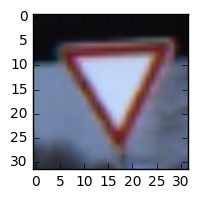

In [194]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

SAMPLE = 14

plt.figure(figsize=(2,2))
plt.imshow(X_train[SAMPLE])
print("This is %d" % y_train[SAMPLE])

In [168]:
X_train.shape

(39209, 32, 32, 3)

In [171]:
X_train[14:15].shape

(1, 32, 32, 3)

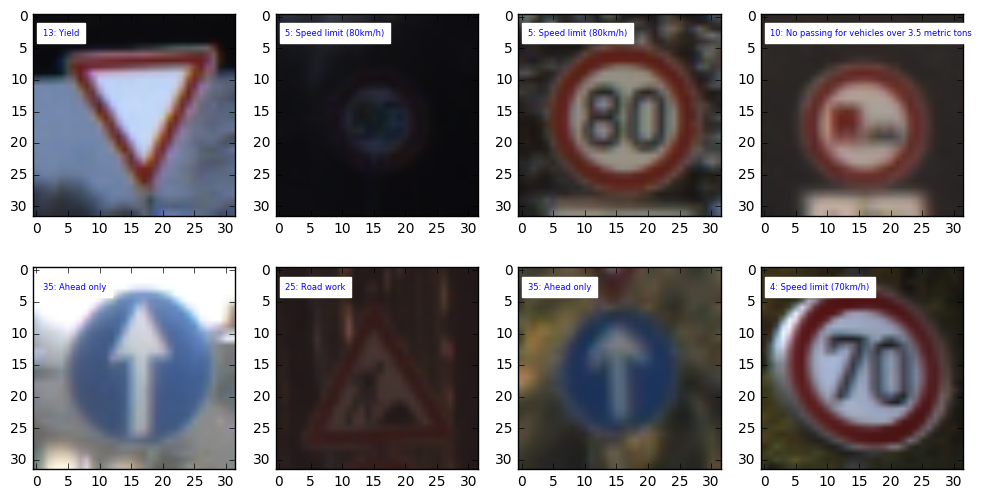

In [209]:
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

samples = X_train[14:22]

def predict_it(samples, model, lb, LABELS):
    predictions = lb.inverse_transform(model.predict(samples))
    
    cols = 4
    rows = ceil(len(samples)/cols)
    plt.figure(figsize = (cols*3, rows*3))
    gs = gridspec.GridSpec(rows, cols)
    
    for i in range(0, len(samples)):
        img = samples[i]
        ax = plt.subplot(gs[i])
        plt.imshow(img)
        txt = "%d: %s" % (predictions[i], LABELS[predictions[i]])
        plt.text(1, 3, txt, color='b', backgroundcolor='w', size=6)
    
predict_it(samples, model, lb, LABELS)

## Testing
Once you've picked out your best model, it's time to test it.

Load up the test data and use the [`evaluate()` method](https://keras.io/models/model/#evaluate) to see how well it does.

Hint 1: The `evaluate()` method should return an array of numbers. Use the [`metrics_names`](https://keras.io/models/model/) property to get the labels.

In [210]:
# TODO: Load test data
with open('test.p', 'rb') as f:
    data_test = pickle.load(f)

X_test = data_test['features']
y_test = data_test['labels']

In [211]:
X_normalized_test = normalize_grayscale(X_test)
y_one_hot_test = lb.fit_transform(y_test)

In [212]:
# evaluate(self, x, y, batch_size=32, verbose=1, sample_weight=None)
# The attribute model.metrics_names will give you the display labels for the scalar outputs.
metrics = model.evaluate(X_normalized_test, y_one_hot_test, batch_size=128)

12630/12630 [==============================] - 3s     

**Test Accuracy:** (fill in here)

In [236]:
for name, value in zip(model.metrics_names, metrics):
    print("%-10s: %.3f" % (name.upper(), value))
    

LOSS      : 0.416
ACC       : 0.901


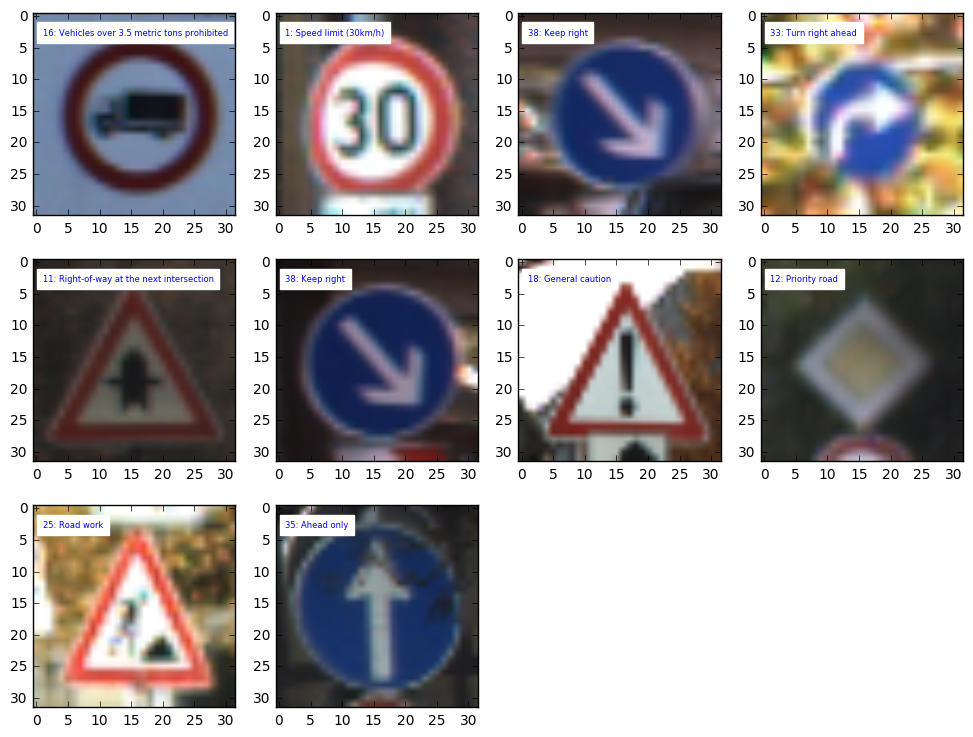

In [237]:
test_set = X_test[0:10]
predict_it(test_set, model, lb, LABELS)

## Summary
Keras is a great tool to use if you want to quickly build a neural network and evaluate performance.